<a href="https://colab.research.google.com/github/basselkassem/probabilistic-ml/blob/main/baysian_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers
print(tf.__version__)
print(tfp.__version__)

2.4.1
0.12.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Prepare TPU

In [3]:
try:
  tpu_ip = f"grpc://{os.environ['COLAB_TPU_ADDR']}"
  tpu_cluster = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_ip)
  tf.config.experimental_connect_to_cluster(tpu_cluster)
  tf.tpu.experimental.initialize_tpu_system(tpu_cluster)
  strategy = tf.distribute.TPUStrategy(tpu_cluster)
  print('Available TPUs:', strategy.num_replicas_in_sync)
except ValueError:
  print(ValueError)

INFO:tensorflow:Initializing the TPU system: grpc://10.119.50.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.50.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Available TPUs: 8


# Load data

In [5]:
# !gdown --id 10VhBL5zo4cOA_28trFCu3WtxFBHbj3yV
# !gdown --id 11013-Bk-iJjVZ1rPn1TFPut12WNhMu5q
# !unzip MNIST_corrupted.zip
# !unzip MNIST.zip

In [6]:
corr_X_train = np.load('MNIST_corrupted/x_train.npy') / 255.0
corr_y_train = np.load('MNIST_corrupted/y_train.npy')
corr_X_test = np.load('MNIST_corrupted/x_test.npy') / 255.0
corr_y_test = np.load('MNIST_corrupted/y_test.npy')

X_train = np.load('MNIST/x_train.npy') / 255.0
y_train = np.load('MNIST/y_train.npy')
X_test = np.load('MNIST/x_test.npy') / 255.0
y_test = np.load('MNIST/y_test.npy')

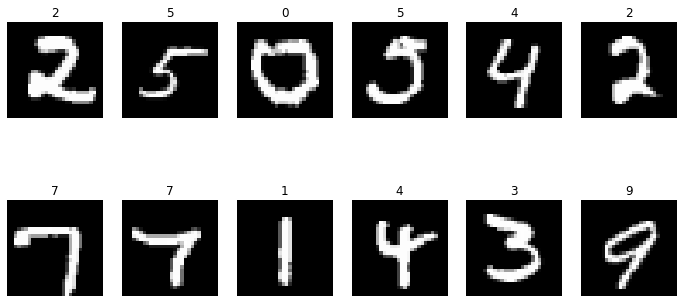

In [7]:
def show_imgs(X, y, elements_num = 12):
  plt.figure(figsize=(12, 6))
  rand = np.random.randint(0, high = len(X), size=elements_num)
  for i, (img, label) in enumerate(zip(X[rand], y[rand])):
    plt.subplot(2, 6, i + 1)
    plt.imshow(img[:,:,0], cmap = 'gray')
    plt.title(label[0])
    plt.axis('off')
  plt.show()

show_imgs(X_train, y_train)

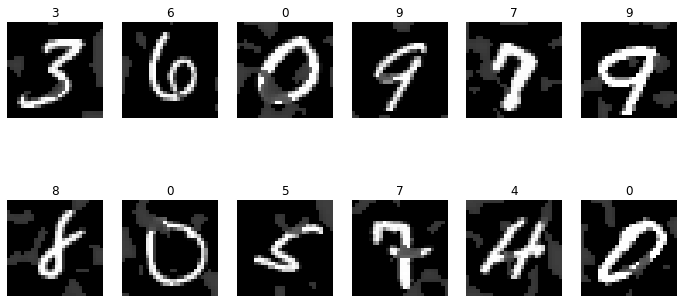

In [9]:
show_imgs(corr_X_train, corr_y_train)

# Determinstic Model

In [10]:
def get_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, 5, padding = 'valid', activation = 'relu', input_shape = (28, 28, 1)),
    tf.keras.layers.MaxPooling2D(6),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'softmax'),
  ])
  model.compile(loss = 'sparse_categorical_crossentropy',
                metrics = ['acc'], optimizer = 'adam',
                steps_per_execution = 50,
                )
  return model


In [11]:
with strategy.scope():
  deterministic_model = get_model()
  deterministic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 1,498
Trainable params: 1,498
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = deterministic_model.fit(
    X_train, y_train, 
    batch_size = 16 * strategy.num_replicas_in_sync, epochs = 10, 
    validation_split = 0.15,
)

Epoch 1/10
399/399 [==============================] - 11s 28ms/step - loss: 1.4057 - acc: 0.6013 - val_loss: 0.3599 - val_acc: 0.8997
Epoch 2/10
399/399 [==============================] - 3s 7ms/step - loss: 0.3147 - acc: 0.9153 - val_loss: 0.2294 - val_acc: 0.9348
Epoch 3/10
399/399 [==============================] - 3s 8ms/step - loss: 0.2165 - acc: 0.9387 - val_loss: 0.1828 - val_acc: 0.9439
Epoch 4/10
399/399 [==============================] - 3s 7ms/step - loss: 0.1761 - acc: 0.9491 - val_loss: 0.1572 - val_acc: 0.9504
Epoch 5/10
399/399 [==============================] - 3s 8ms/step - loss: 0.1533 - acc: 0.9538 - val_loss: 0.1418 - val_acc: 0.9546
Epoch 6/10
399/399 [==============================] - 3s 8ms/step - loss: 0.1395 - acc: 0.9583 - val_loss: 0.1259 - val_acc: 0.9606
Epoch 7/10
399/399 [==============================] - 3s 8ms/step - loss: 0.1277 - acc: 0.9630 - val_loss: 0.1182 - val_acc: 0.9624
Epoch 8/10
399/399 [==============================] - 3s 8ms/step - loss: 

In [13]:
print('Accuracy on MNIST test set: ',
      str(deterministic_model.evaluate(X_test, y_test, verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(deterministic_model.evaluate(corr_X_test, corr_y_test, verbose=False)[1]))

Accuracy on MNIST test set:  0.9721999764442444
Accuracy on corrupted MNIST test set:  0.9340999722480774


# Probabilistic Model

## Aleatoric Uncertainty

In [14]:
def nll(y_true, y_hat_dist):
  return -y_hat_dist.log_prob(y_true)

In [15]:
def get_aleatoric_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, 5, padding = 'valid', activation = 'relu', input_shape = (28, 28, 1)),
    tf.keras.layers.MaxPooling2D(6),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(tfpl.OneHotCategorical.params_size(10),),
    tfpl.OneHotCategorical(event_size = 10, convert_to_tensor_fn = tfd.Distribution.mode)
  ])
  model.compile(loss = nll,
                metrics = ['acc'], optimizer = 'adam',
                steps_per_execution = 50,
                )
  return model

In [16]:
with strategy.scope():
  aleatoric_model = get_aleatoric_model()
  aleatoric_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
one_hot_categorical (OneHotC multiple                  0         
Total params: 1,498
Trainable params: 1,498
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = aleatoric_model.fit(
    X_train, tf.keras.utils.to_categorical(y_train),
    batch_size = 16 * strategy.num_replicas_in_sync, epochs = 10, 
    validation_split = 0.15,
)

Epoch 1/10
399/399 [==============================] - 11s 27ms/step - loss: 1.3663 - acc: 0.6244 - val_loss: 0.3082 - val_acc: 0.9148
Epoch 2/10
399/399 [==============================] - 3s 8ms/step - loss: 0.2725 - acc: 0.9262 - val_loss: 0.1871 - val_acc: 0.9449
Epoch 3/10
399/399 [==============================] - 3s 8ms/step - loss: 0.1833 - acc: 0.9475 - val_loss: 0.1493 - val_acc: 0.9554
Epoch 4/10
399/399 [==============================] - 3s 8ms/step - loss: 0.1461 - acc: 0.9576 - val_loss: 0.1276 - val_acc: 0.9601
Epoch 5/10
399/399 [==============================] - 3s 8ms/step - loss: 0.1308 - acc: 0.9615 - val_loss: 0.1186 - val_acc: 0.9634
Epoch 6/10
399/399 [==============================] - 3s 8ms/step - loss: 0.1222 - acc: 0.9641 - val_loss: 0.1094 - val_acc: 0.9624
Epoch 7/10
399/399 [==============================] - 3s 8ms/step - loss: 0.1101 - acc: 0.9684 - val_loss: 0.1021 - val_acc: 0.9670
Epoch 8/10
399/399 [==============================] - 3s 8ms/step - loss: 

In [18]:
print('Accuracy on MNIST test set: ',
      str(aleatoric_model.evaluate(X_test, tf.keras.utils.to_categorical(y_test), verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(aleatoric_model.evaluate(corr_X_test, tf.keras.utils.to_categorical(corr_y_test), verbose=False)[1]))

Accuracy on MNIST test set:  0.9734999537467957
Accuracy on corrupted MNIST test set:  0.9420999884605408


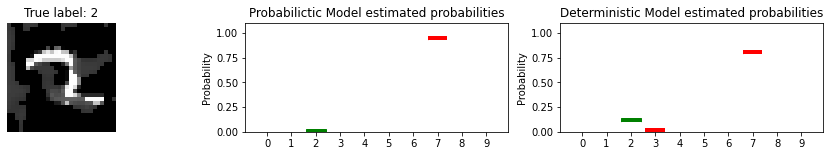

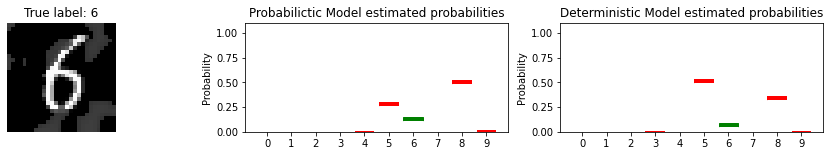

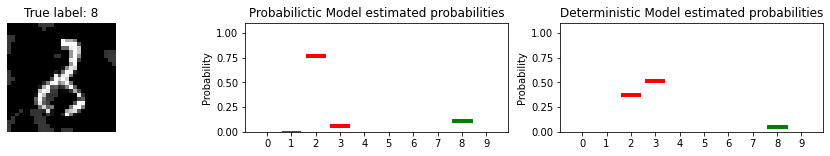

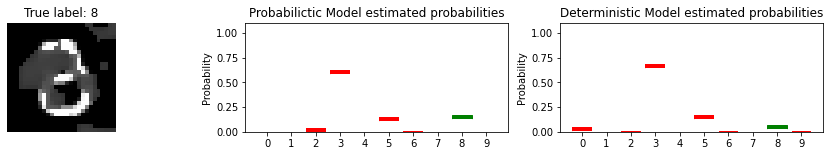

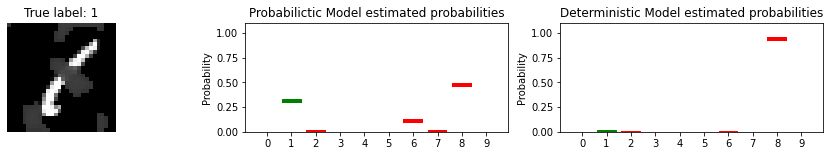

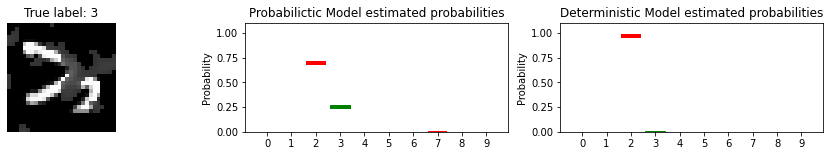

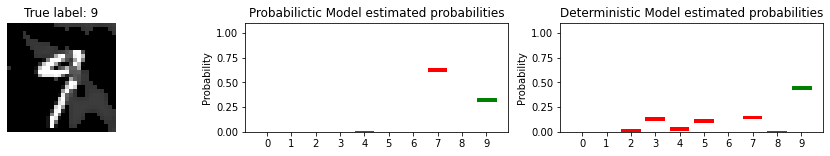

In [88]:
def get_prediction(data, model, image, run_ensemble = False, deter = False):
  if run_ensemble:
    ensemble_size = 200
  else:
    ensemble_size = 1
  
  predicted_probabilities = np.empty(shape=(ensemble_size, 10))
  for i in range(ensemble_size):
    if deter == True:
      predicted_probabilities[i] = model(image[np.newaxis, :]).numpy()[0]
    else:
      predicted_probabilities[i] = model(image[np.newaxis, :]).mean().numpy()[0]

  model_prediction = model(image[np.newaxis, :])
  model1_pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(10)])
  model2_pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(10)])
  return model1_pct_2p5, model2_pct_97p5


def analyse_model_prediction(data, labels, model1, model2,  image_num, run_ensemble=False, deter = True):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 2))
    true_label = labels[image_num, 0]
    image = data[image_num]
    model1_pct_2p5, model1_pct_97p5 = get_prediction(data, model1, image, run_ensemble)
    model2_pct_2p5, model2_pct_97p5 = get_prediction(data, model2, image, run_ensemble, deter)

    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
      
    bar = ax2.bar(np.arange(10), model1_pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(10), model1_pct_2p5-0.04, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(10))
    ax2.set_ylim([0, 1.1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Probabilictic Model estimated probabilities')

    bar = ax3.bar(np.arange(10), model2_pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax3.bar(np.arange(10), model2_pct_2p5-0.04, color='white', linewidth=1, edgecolor='white')
    ax3.set_xticks(np.arange(10))
    ax3.set_ylim([0, 1.1])
    ax3.set_ylabel('Probability')
    ax3.set_title('Deterministic Model estimated probabilities')
    plt.show()

y_hat = np.argmax(aleatoric_model(corr_X_test).mean().numpy(), axis=-1)
miss_cls = np.where(corr_y_test.reshape(-1, ) != y_hat)[0]
for i in miss_cls[0:7]:
    analyse_model_prediction(corr_X_test, corr_y_test, aleatoric_model, deterministic_model, i)

In [26]:
def get_correct_indices(model, x, labels):
    y_model = model(x)
    correct = np.argmax(y_model.mean(), axis=1) == np.squeeze(labels)
    correct_indices = [i for i in range(x.shape[0]) if correct[i]]
    incorrect_indices = [i for i in range(x.shape[0]) if not correct[i]]
    return correct_indices, incorrect_indices


def plot_entropy_distribution(model, x, labels):
    probs = model(x).mean().numpy()
    entropy = -np.sum(probs * np.log2(probs), axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i, category in zip(range(2), ['Correct', 'Incorrect']):
        entropy_category = entropy[get_correct_indices(model, x, labels)[i]]
        mean_entropy = np.mean(entropy_category)
        num_samples = entropy_category.shape[0]
        title = category + 'ly labelled ({:.1f}% of total)'.format(num_samples / x.shape[0] * 100)
        axes[i].hist(entropy_category, weights=(1/num_samples)*np.ones(num_samples))
        axes[i].annotate('Mean: {:.3f} bits'.format(mean_entropy), (0.4, 0.9), ha='center')
        axes[i].set_xlabel('Entropy (bits)')
        axes[i].set_ylim([0, 1])
        axes[i].set_ylabel('Probability')
        axes[i].set_title(title)
    plt.show()

MNIST test set:


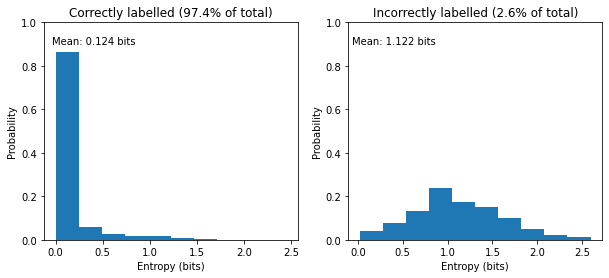

In [27]:
print('MNIST test set:')
plot_entropy_distribution(aleatoric_model, X_test, y_test)

Corrupted MNIST test set:


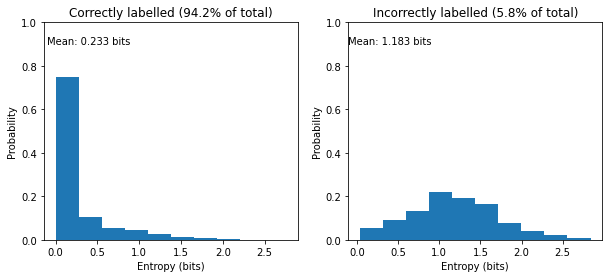

In [28]:
print('Corrupted MNIST test set:')
plot_entropy_distribution(aleatoric_model, corr_X_test, corr_y_test)

## Epistemic Uncertainty

In [80]:
def get_prior(kernel_size, bias_size, dtype = None):
  kernel_loc = tf.zeros((kernel_size, ))
  kernel_scale = tf.ones((kernel_size, ))
  kernel_prior = tfd.Normal(kernel_loc, kernel_scale)
  bias_loc = tf.zeros((kernel_size, ))
  bias_scale = tf.ones((kernel_size, ))
  bias_prior = tfd.Normal(bias_loc, bias_scale)
  return kernel_prior, bias_prior

def loss(y_true, y_hat_dist):
  return -y_hat_dist.log_prob(y_true)

In [95]:
def get_epistemic_model():
  divergenc_fn = lambda q, p, _: tfd.kl_divergence(q, p) / X_train.shape[0]
  model = tf.keras.models.Sequential([
    tfpl.Convolution2DReparameterization(
        8, 5, padding = 'same', input_shape = (28, 28, 1), activation = 'relu',
        kernel_prior_fn = tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn = tfpl.default_mean_field_normal_fn(),
        kernel_divergence_fn = divergenc_fn,
        bias_prior_fn = tfpl.default_multivariate_normal_fn,
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(),
        bias_divergence_fn = divergenc_fn,
    ),
    tf.keras.layers.MaxPooling2D(6),
    tf.keras.layers.Flatten(),
    tfpl.DenseReparameterization(
        tfpl.OneHotCategorical.params_size(10),
        kernel_prior_fn = tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn = tfpl.default_mean_field_normal_fn(),
        kernel_divergence_fn = divergenc_fn,
        bias_prior_fn = tfpl.default_multivariate_normal_fn,
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(),
        bias_divergence_fn = divergenc_fn,
    ),
    tfpl.OneHotCategorical(event_size = 10)
  ])
  model.compile(loss = loss, optimizer = 'adam', metrics = ['accuracy'])
  return model

In [96]:
epistemic_model = get_epistemic_model()
epistemic_model.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_19 (None, 28, 28, 8)         416       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_reparameterization_17  (None, 10)                2580      
_________________________________________________________________
one_hot_categorical_18 (OneH multiple                  0         
Total params: 2,996
Trainable params: 2,996
Non-trainable params: 0
_________________________________________________________________


In [97]:
history = epistemic_model.fit(
    X_train, tf.keras.utils.to_categorical(y_train),
    batch_size = 16 * strategy.num_replicas_in_sync, epochs = 10, 
    validation_split = 0.15,
)

Epoch 1/10
399/399 [==============================] - 8s 17ms/step - loss: 1.8259 - accuracy: 0.2379 - val_loss: 0.6355 - val_accuracy: 0.6808
Epoch 2/10
399/399 [==============================] - 6s 15ms/step - loss: 0.5727 - accuracy: 0.7211 - val_loss: 0.4265 - val_accuracy: 0.8037
Epoch 3/10
399/399 [==============================] - 6s 15ms/step - loss: 0.4003 - accuracy: 0.8151 - val_loss: 0.3439 - val_accuracy: 0.8432
Epoch 4/10
399/399 [==============================] - 6s 15ms/step - loss: 0.3345 - accuracy: 0.8559 - val_loss: 0.2948 - val_accuracy: 0.8791
Epoch 5/10
399/399 [==============================] - 6s 15ms/step - loss: 0.2937 - accuracy: 0.8773 - val_loss: 0.2672 - val_accuracy: 0.8924
Epoch 6/10
399/399 [==============================] - 6s 15ms/step - loss: 0.2674 - accuracy: 0.8940 - val_loss: 0.2497 - val_accuracy: 0.9042
Epoch 7/10
399/399 [==============================] - 6s 15ms/step - loss: 0.2498 - accuracy: 0.9050 - val_loss: 0.2249 - val_accuracy: 0.9119

In [84]:
print('Accuracy on MNIST test set: ',
      str(epistemic_model.evaluate(X_test, tf.keras.utils.to_categorical(y_test), verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(epistemic_model.evaluate(corr_X_test, tf.keras.utils.to_categorical(corr_y_test), verbose=False)[1]))

Accuracy on MNIST test set:  0.9373000264167786
Accuracy on corrupted MNIST test set:  0.89410001039505


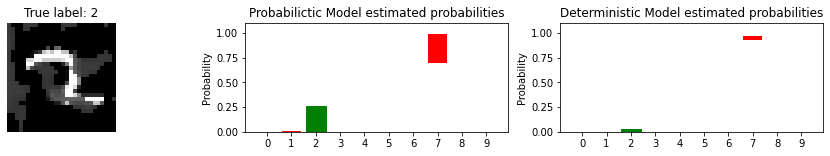

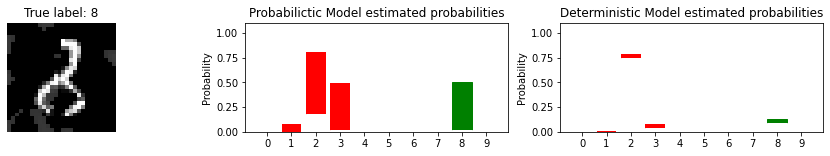

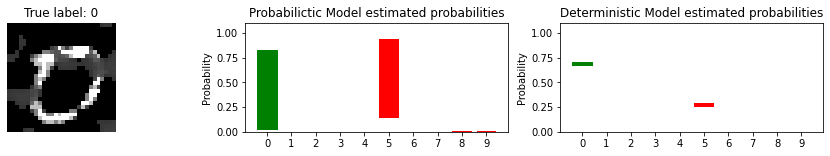

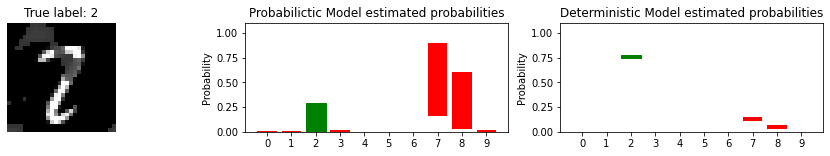

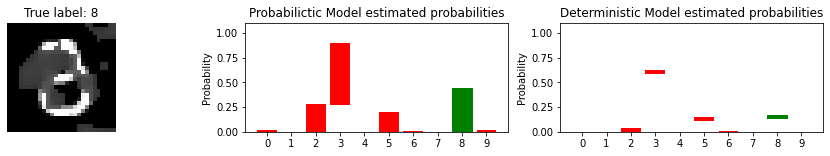

In [90]:
y_hat = np.argmax(epistemic_model(corr_X_test).mean().numpy(), axis=-1)
miss_cls = np.where(corr_y_test.reshape(-1, ) != y_hat)[0]
for i in miss_cls[0:5]:
    analyse_model_prediction(corr_X_test, corr_y_test, epistemic_model, aleatoric_model, i, run_ensemble=True, deter = False)

MNIST test set:


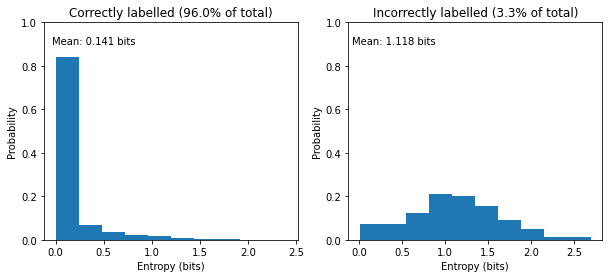

In [91]:
print('MNIST test set:')
plot_entropy_distribution(epistemic_model, X_test, y_test)

Corrupted MNIST test set:


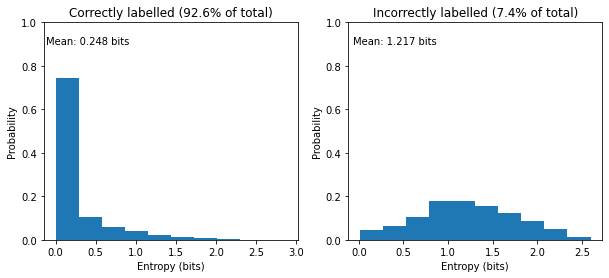

In [92]:
print('Corrupted MNIST test set:')
plot_entropy_distribution(epistemic_model, corr_X_test, corr_y_test)

# Reparameterization Vs. Variational

In [228]:
def get_prior(kernel_size, bias_size, dtype = None):
  n = kernel_size + bias_size
  return lambda t: tfd.Independent(
      tfd.Normal(loc = tf.zeros(n, dtype), scale = 1.),
      reinterpreted_batch_ndims = 1,
  )
def get_posterior(kernel_size, bais_size, dtype = None):
  n = kernel_size + bais_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfpl.VariableLayer(2 * n, dtype=dtype),
      tfpl.IndependentNormal(n),
  ])

In [229]:
def get_epistemic_model2():
  divergenc_fn = lambda q, p, _: tfd.kl_divergence(q, p) / X_train.shape[0]
  model = tf.keras.models.Sequential([
    tfpl.Convolution2DReparameterization(
        8, 5, padding = 'same', input_shape = (28, 28, 1), activation = 'relu',
        kernel_prior_fn = tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn = tfpl.default_mean_field_normal_fn(),
        kernel_divergence_fn = divergenc_fn,
        bias_prior_fn = tfpl.default_multivariate_normal_fn,
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(),
        bias_divergence_fn = divergenc_fn,
    ),
    tf.keras.layers.MaxPooling2D(6),
    tf.keras.layers.Flatten(),
    tfpl.DenseVariational(
        tfpl.OneHotCategorical.params_size(10),
        make_posterior_fn = get_posterior,
        make_prior_fn = get_prior,
        kl_use_exact = True,
        kl_weight = 1 / X_train.shape[0],
        activation = None,
    ),
    tfpl.OneHotCategorical(event_size = 10)
  ])
  model.compile(loss = loss, optimizer = 'adam', metrics = ['accuracy'])
  return model

In [230]:
model2 = get_epistemic_model2()
model2.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_57 (None, 28, 28, 8)         416       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_58 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_variational_37 (DenseV (None, 10)                2580      
_________________________________________________________________
one_hot_categorical_56 (OneH multiple                  0         
Total params: 2,996
Trainable params: 2,996
Non-trainable params: 0
_________________________________________________________________


In [231]:
history = model2.fit(
    X_train, tf.keras.utils.to_categorical(y_train),
    batch_size = 16 * strategy.num_replicas_in_sync, epochs = 40, 
    validation_split = 0.15,
)

Epoch 1/40
399/399 [==============================] - 7s 16ms/step - loss: 2.9440 - accuracy: 0.1051 - val_loss: 2.4901 - val_accuracy: 0.1003
Epoch 2/40
399/399 [==============================] - 6s 14ms/step - loss: 2.4592 - accuracy: 0.1026 - val_loss: 2.4340 - val_accuracy: 0.1052
Epoch 3/40
399/399 [==============================] - 6s 14ms/step - loss: 2.4016 - accuracy: 0.1103 - val_loss: 2.1586 - val_accuracy: 0.1552
Epoch 4/40
399/399 [==============================] - 6s 15ms/step - loss: 1.9769 - accuracy: 0.1991 - val_loss: 1.4653 - val_accuracy: 0.3596
Epoch 5/40
399/399 [==============================] - 6s 15ms/step - loss: 1.3531 - accuracy: 0.4105 - val_loss: 1.0560 - val_accuracy: 0.5206
Epoch 6/40
399/399 [==============================] - 6s 15ms/step - loss: 0.9900 - accuracy: 0.5486 - val_loss: 0.8423 - val_accuracy: 0.6072
Epoch 7/40
399/399 [==============================] - 6s 15ms/step - loss: 0.7941 - accuracy: 0.6323 - val_loss: 0.6960 - val_accuracy: 0.6758

In [232]:
print('Accuracy on MNIST test set: ',
      str(model2.evaluate(X_test, tf.keras.utils.to_categorical(y_test), verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(model2.evaluate(corr_X_test, tf.keras.utils.to_categorical(corr_y_test), verbose=False)[1]))

Accuracy on MNIST test set:  0.9448000192642212
Accuracy on corrupted MNIST test set:  0.8919000029563904


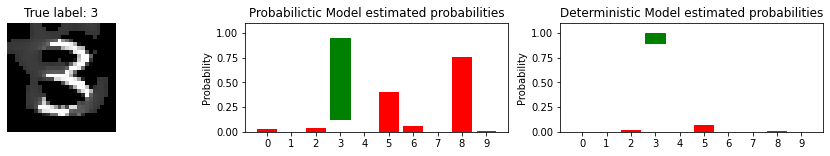

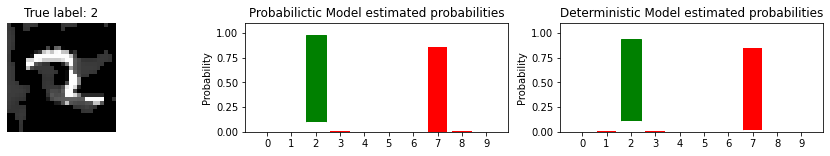

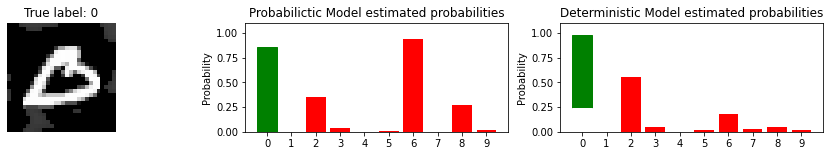

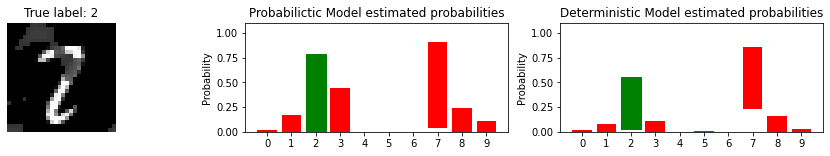

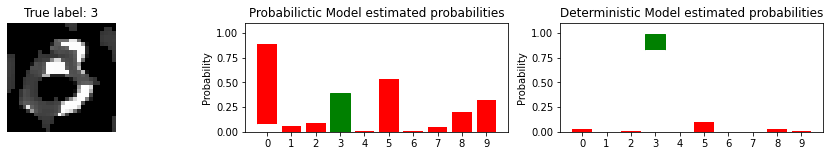

In [233]:
y_hat = np.argmax(model2(corr_X_test).mean().numpy(), axis=-1)
miss_cls = np.where(corr_y_test.reshape(-1, ) != y_hat)[0]
for i in miss_cls[0:5]:
    analyse_model_prediction(corr_X_test, corr_y_test, model2, epistemic_model, i, run_ensemble=True, deter = False)

MNIST test set:


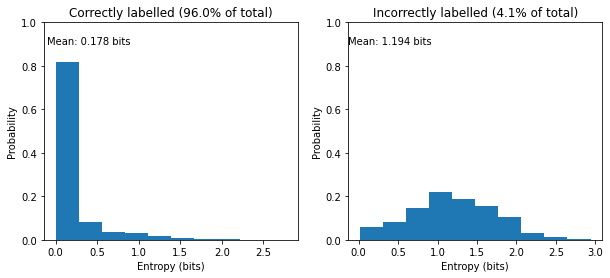

In [234]:
print('MNIST test set:')
plot_entropy_distribution(epistemic_model, X_test, y_test)


Corrupted MNIST test set:


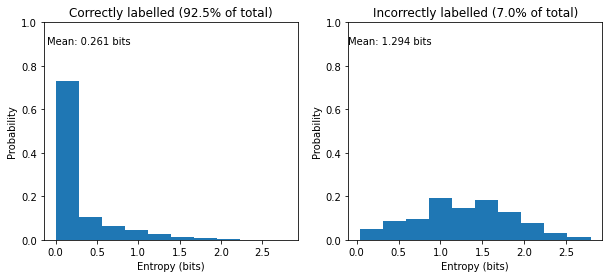

In [235]:
print('Corrupted MNIST test set:')
plot_entropy_distribution(epistemic_model, corr_X_test, corr_y_test)